In [34]:
import numpy as np
import pandas as pd
import wget
from multiprocessing.dummy import Pool as ThreadPool 
from ipfx.dataset.create import create_ephys_data_set
from ipfx.data_set_features import extract_data_set_features
from ipfx.utilities import drop_failed_sweeps
import numpy as np
import argschema as ags
import logging
import traceback
from multiprocessing import Pool
from functools import partial
import os
import h5py
from ipfx.stimulus import StimulusOntology
import allensdk.core.json_utilities as ju
import ipfx.feature_vectors as fv
import ipfx.lims_queries as lq
import ipfx.script_utils as su
from ipfx.dataset.create import create_ephys_data_set
import pickle
import json
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.cluster import DBSCAN, KMeans
import seaborn as sns
import matplotlib.pyplot as plt

sweep_qc_option = 'none'
include_failed_cells = False
ap_window_length = 0.003
target_sampling_rate=50000
ontology = StimulusOntology(ju.read(StimulusOntology.DEFAULT_STIMULUS_ONTOLOGY_FILE))

# data link
Gouwens, N. W., Sorensen, S. A., Baftizadeh, F., Budzillo, A., Lee, B. R., Jarsky, T., ... & Zeng, H. (2020). Integrated morphoelectric and transcriptomic classification of cortical GABAergic cells. Cell, 183(4), 935-953. https://doi.org/10.1016/j.cell.2020.09.057

In [54]:
data_set = create_ephys_data_set(nwb_file=nwb_path)
lsq_sweep_numbers = su.categorize_iclamp_sweeps(data_set,
        ontology.long_square_names, sweep_qc_option=sweep_qc_option,
        specimen_id=specimen_id)
(lsq_sweeps,
lsq_features,
_,
lsq_start,
lsq_end) = su.preprocess_long_square_sweeps(data_set, lsq_sweep_numbers)
print(lsq_start, lsq_end)
print(lsq_features.keys())

C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


1.02 2.0199999999999996
dict_keys(['spikes_set', 'sweeps', 'v_baseline', 'rheobase_i', 'rheobase_sweep', 'spiking_sweeps', 'fi_fit_slope', 'hero_sweep', 'sag', 'vm_for_sag', 'subthreshold_sweeps', 'subthreshold_membrane_property_sweeps', 'input_resistance', 'tau'])


In [60]:
(subthresh_hyperpol_dict,
hyperpol_deflect_dict) = fv.identify_subthreshold_hyperpol_with_amplitudes(lsq_features,
    lsq_sweeps)

a = subthresh_hyperpol_dict[-110]
print(subthresh_hyperpol_dict.keys())
print(a.sweep_number)
print(hyperpol_deflect_dict)

dict_keys([-110.0, -70.0, -90.0, -50.0, -30.0, -10.0])
31
{-110.0: (-66.34811401367188, -87.59376), -70.0: (-66.26939392089844, -79.9375), -90.0: (-65.60835266113281, -82.25001), -50.0: (-64.71922302246094, -75.125), -30.0: (-65.75650024414062, -72.18751), -10.0: (-65.58529663085938, -68.53125)}


In [2]:
def get_feature(nwb_path, specimen_id):
    data_set = create_ephys_data_set(nwb_file=nwb_path)
    lsq_sweep_numbers = su.categorize_iclamp_sweeps(data_set,
            ontology.long_square_names, sweep_qc_option=sweep_qc_option,
            specimen_id=specimen_id)
    (lsq_sweeps,
    lsq_features,
    _,
    lsq_start,
    lsq_end) = su.preprocess_long_square_sweeps(data_set, lsq_sweep_numbers)

    ssq_sweep_numbers = su.categorize_iclamp_sweeps(data_set,
        ontology.short_square_names, sweep_qc_option=sweep_qc_option,
        specimen_id=specimen_id)
    ssq_sweeps, ssq_features, _ = su.preprocess_short_square_sweeps(data_set,
        ssq_sweep_numbers)

    ramp_sweep_numbers = su.categorize_iclamp_sweeps(data_set,
        ontology.ramp_names, sweep_qc_option=sweep_qc_option,
        specimen_id=specimen_id)
    ramp_sweeps, ramp_features, _ = su.preprocess_ramp_sweeps(data_set,
        ramp_sweep_numbers)

    result = {}

    (subthresh_hyperpol_dict,
    hyperpol_deflect_dict) = fv.identify_subthreshold_hyperpol_with_amplitudes(lsq_features,
        lsq_sweeps)
    target_amps_for_step_subthresh = [-90, -70, -50, -30, -10]
    result["step_subthresh"] = fv.step_subthreshold(
        subthresh_hyperpol_dict, target_amps_for_step_subthresh,
        lsq_start, lsq_end, amp_tolerance=5)
    result["subthresh_norm"] = fv.subthresh_norm(subthresh_hyperpol_dict, hyperpol_deflect_dict,
        lsq_start, lsq_end)
    (subthresh_depol_dict,
    depol_deflect_dict) = fv.identify_subthreshold_depol_with_amplitudes(lsq_features,
        lsq_sweeps)
    result["subthresh_depol_norm"] = fv.subthresh_depol_norm(
        subthresh_depol_dict,
        depol_deflect_dict,
        np.round(lsq_start, decimals=3),
        np.round(lsq_end, decimals=3))
    isi_sweep, isi_sweep_spike_info = fv.identify_sweep_for_isi_shape(
        lsq_sweeps, lsq_features, lsq_end - lsq_start)
    result["isi_shape"] = fv.isi_shape(isi_sweep, isi_sweep_spike_info, lsq_end)


    spiking_ssq_sweep_list = [ssq_sweeps.sweeps[swp_ind]
        for swp_ind in ssq_features["common_amp_sweeps"].index]
    spiking_ssq_info_list = [ssq_features["spikes_set"][swp_ind]
        for swp_ind in ssq_features["common_amp_sweeps"].index]
    ssq_ap_v, ssq_ap_dv = fv.first_ap_vectors(spiking_ssq_sweep_list,
        spiking_ssq_info_list,
        target_sampling_rate=target_sampling_rate,
        window_length=ap_window_length,
        skip_clipped=True)

    rheo_ind = lsq_features["rheobase_sweep"].name
    sweep = lsq_sweeps.sweeps[rheo_ind]
    lsq_ap_v, lsq_ap_dv = fv.first_ap_vectors([sweep],
        [lsq_features["spikes_set"][rheo_ind]],
        target_sampling_rate=target_sampling_rate,
        window_length=ap_window_length)

    spiking_ramp_sweep_list = [ramp_sweeps.sweeps[swp_ind]
        for swp_ind in ramp_features["spiking_sweeps"].index]
    spiking_ramp_info_list = [ramp_features["spikes_set"][swp_ind]
        for swp_ind in ramp_features["spiking_sweeps"].index]
    ramp_ap_v, ramp_ap_dv = fv.first_ap_vectors(spiking_ramp_sweep_list,
        spiking_ramp_info_list,
        target_sampling_rate=target_sampling_rate,
        window_length=ap_window_length,
        skip_clipped=True)

    result["first_ap_v"] = np.hstack([ssq_ap_v, lsq_ap_v, ramp_ap_v])
    result["first_ap_dv"] = np.hstack([ssq_ap_dv, lsq_ap_dv, ramp_ap_dv])

    target_amplitudes = np.arange(0, 120, 20)
    supra_info_list = fv.identify_suprathreshold_spike_info(
        lsq_features, target_amplitudes, shift=10)
    result["psth"] = fv.psth_vector(supra_info_list, lsq_start, lsq_end)
    result["inst_freq"] = fv.inst_freq_vector(supra_info_list, lsq_start, lsq_end)

    spike_feature_list = [
        "upstroke_downstroke_ratio",
        "peak_v",
        "fast_trough_v",
        "threshold_v",
        "width",
    ]
    for feature in spike_feature_list:
        result["spiking_" + feature] = fv.spike_feature_vector(feature,
            supra_info_list, lsq_start, lsq_end)
    return result

## Metadata file
The metadata file has information about each Patch-seq cell, including its different identifiers and assigned cell types.

In [3]:
metadata = pd.read_csv("./20200711_patchseq_metadata_mouse.csv")
metadata

,project,cell_specimen_id,cell_specimen_name,hemisphere,structure,donor_id,donor_name,biological_sex,age,ethnicity,...,apical_dendrite_status,neuron_reconstruction_type,cell_soma_normalized_depth,depth_from_pia_um,ephys_session_id,transcriptomics_sample_id,transcriptomics_batch,T-type Accession ID,T-type Label,MET-type Label
0,mIVSCC-MET,601506507,Vip-IRES-Cre;Ai14-331294.04.01.01,left,VISpm4,331294,Vip-IRES-Cre;Ai14-331294,M,P55,NaN,...,NaN,full,0.361015,NaN,601506492,PS0810_E1-50_S88,BT035,CS180626100018,Vip Gpc3 Slc18a3,Vip-MET-2
1,mIVSCC-MET,601790961,Sst-IRES-Cre;Ai14-331663.04.01.01,left,VISpm5,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.621829,NaN,601790945,PS0817_E1-50_S19,BT036,CS180626100041,Sst Tac2 Myh4,NaN
2,mIVSCC-MET,601803754,Sst-IRES-Cre;Ai14-331663.04.02.02,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.164240,NaN,601803733,PS0817_E1-50_S25,BT036,CS180626100035,Sst Calb2 Pdlim5,Sst-MET-3
3,mIVSCC-MET,601808698,Sst-IRES-Cre;Ai14-331663.04.02.03,right,VISp5,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.483030,NaN,601808619,PS0817_E1-50_S26,BT036,CS180626100043,Sst Hpse Cbln4,Sst-MET-8
4,mIVSCC-MET,601810307,Sst-IRES-Cre;Ai14-331663.04.02.04,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.295656,NaN,601810292,PS0817_E1-50_S27,BT036,CS180626100034,Sst Calb2 Necab1,Sst-MET-3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4430,mIVSCC-MET,1003020818,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508158...,right,VISp5,508158,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508158,M,P54,NaN,...,NaN,NaN,NaN,NaN,1003020741,SM-J39S6_S190_E1-50,RSC-248,CS180626100006,Lamp5 Lsp1,NaN
4431,mIVSCC-MET,1003305641,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159...,left,VISl2/3,508159,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159,M,P55,NaN,...,NaN,NaN,NaN,NaN,1003305489,SM-J3A1L_S592_E1-50,RSC-250,CS180626100060,Pvalb Vipr2,NaN
4432,mIVSCC-MET,1003313398,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159...,left,VISp2/3,508159,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159,M,P55,NaN,...,NaN,NaN,NaN,NaN,1003313230,SM-J3A1L_S593_E1-50,RSC-250,CS180626100060,Pvalb Vipr2,NaN
4433,mIVSCC-MET,1003321825,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159...,left,VISp2/3,508159,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159,M,P55,NaN,...,NaN,NaN,NaN,NaN,1003321768,SM-J3A1L_S603_E1-50,RSC-250,CS180626100060,Pvalb Vipr2,NaN


In [4]:
(metadata['structure'].value_counts())

VISp2/3      1148
VISp5        1120
VISp6a        729
VISp4         388
VISp1         239
VISpm5        139
VISpm2/3      117
VISl5          78
VISpm6a        66
VISl2/3        59
VISl6a         43
VISpm4         39
VISpm1         30
VISp6b         25
VISpor5        22
VISl4          19
VISli5         16
VISl1          15
VISli2/3       13
VISpor6a       12
VISpor2/3      11
VISpl6a        10
VISpl5          8
VISam5          8
VISam4          8
VISal5          7
VISam2/3        6
VISam6a         5
VISal6a         5
VISli6a         5
VISli4          5
VISpor1         4
VISal2/3        4
VISrl5          4
VISl6b          4
VISrl2/3        3
VISal4          3
VISli1          2
VISpor4         2
VISal1          2
VISrl6a         2
VISrl4          2
VISpl2/3        2
VISpor6b        1
VISli6b         1
VISa5           1
VISpl4          1
VISa6a          1
VISp            1
Name: structure, dtype: int64

In [5]:
metadata = metadata[metadata.structure.isin(['VISp2/3', 'VISp5', 'VISp6a', 'VISp4', 'VISp1', 'VISp'])]
metadata

,project,cell_specimen_id,cell_specimen_name,hemisphere,structure,donor_id,donor_name,biological_sex,age,ethnicity,...,apical_dendrite_status,neuron_reconstruction_type,cell_soma_normalized_depth,depth_from_pia_um,ephys_session_id,transcriptomics_sample_id,transcriptomics_batch,T-type Accession ID,T-type Label,MET-type Label
2,mIVSCC-MET,601803754,Sst-IRES-Cre;Ai14-331663.04.02.02,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.164240,NaN,601803733,PS0817_E1-50_S25,BT036,CS180626100035,Sst Calb2 Pdlim5,Sst-MET-3
3,mIVSCC-MET,601808698,Sst-IRES-Cre;Ai14-331663.04.02.03,right,VISp5,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.483030,NaN,601808619,PS0817_E1-50_S26,BT036,CS180626100043,Sst Hpse Cbln4,Sst-MET-8
4,mIVSCC-MET,601810307,Sst-IRES-Cre;Ai14-331663.04.02.04,right,VISp2/3,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.295656,NaN,601810292,PS0817_E1-50_S27,BT036,CS180626100034,Sst Calb2 Necab1,Sst-MET-3
5,mIVSCC-MET,601811091,Sst-IRES-Cre;Ai14-331663.03.01.01,left,VISp6a,331663,Sst-IRES-Cre;Ai14-331663,F,P57,NaN,...,NaN,full,0.766595,NaN,601811076,PS0817_E1-50_S28,BT036,CS180626100046,Sst Esm1,Sst-MET-13
6,mIVSCC-MET,602231708,Sst-IRES-Cre;Ai14-331660.06.02.01,right,VISp5,331660,Sst-IRES-Cre;Ai14-331660,M,P59,NaN,...,NaN,full,0.589005,NaN,602231628,PS0817_E1-50_S46,BT036,CS180626100035,Sst Calb2 Pdlim5,Sst-MET-4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4429,mIVSCC-MET,993959787,Oxtr-T2A-Cre;Ai14-500776.04.01.02,left,VISp2/3,500776,Oxtr-T2A-Cre;Ai14-500776,M,P57,NaN,...,NaN,NaN,NaN,NaN,993959730,SM-J39T2_S314_E1-50,RSC-244,CS180626100006,Lamp5 Lsp1,NaN
4430,mIVSCC-MET,1003020818,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508158...,right,VISp5,508158,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508158,M,P54,NaN,...,NaN,NaN,NaN,NaN,1003020741,SM-J39S6_S190_E1-50,RSC-248,CS180626100006,Lamp5 Lsp1,NaN
4432,mIVSCC-MET,1003313398,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159...,left,VISp2/3,508159,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159,M,P55,NaN,...,NaN,NaN,NaN,NaN,1003313230,SM-J3A1L_S593_E1-50,RSC-250,CS180626100060,Pvalb Vipr2,NaN
4433,mIVSCC-MET,1003321825,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159...,left,VISp2/3,508159,Vipr2-IRES2-Cre;Slc32a1-IRES2-FlpO;Ai65-508159,M,P55,NaN,...,NaN,NaN,NaN,NaN,1003321768,SM-J3A1L_S603_E1-50,RSC-250,CS180626100060,Pvalb Vipr2,NaN


In [6]:
metadata.columns

Index(['project', 'cell_specimen_id', 'cell_specimen_name', 'hemisphere',
       'structure', 'donor_id', 'donor_name', 'biological_sex', 'age',
       'ethnicity', 'medical_conditions', 'full_genotype', 'dendrite_type',
       'apical_dendrite_status', 'neuron_reconstruction_type',
       'cell_soma_normalized_depth', 'depth_from_pia_um', 'ephys_session_id',
       'transcriptomics_sample_id', 'transcriptomics_batch',
       'T-type Accession ID', 'T-type Label', 'MET-type Label'],
      dtype='object')

## File manifest
The file manifest contains URLs for the different data files associated with the Patch-seq cells that are located in various archives.

In [7]:
file_manifest = pd.read_excel('./2021-09-13_mouse_file_manifest.xlsx', engine='openpyxl',)
file_manifest.head()

,file_id,file_name,file_size,sha256_checksum,md5_checksum,technique,file_type,archive,archive_uri,project,cell_specimen_id
0,601506507,601506507.marker,268,305938ce75d55c3f43fbbe2d1d57e203139fa0c357bd73...,ecf2285ccbf5274af7d6a31a855ce950,morphology,marker_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601506507.0
1,601506507,601506507_raw.swc,160503,6c82f5f974e4f6d2336a3606d4955823edd3c0173da60d...,7cc7ccdd627ef83fe54fcbf0feac79c2,morphology,raw_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601506507.0
2,601506507,601506507_transformed.swc,271764,bad13a99c8f7f8a375e43109d80fd23d7028555a7dc42b...,f6a365d86ff65370af26439f0f16caaf,morphology,transformed_swc,BIL,ftp://download.brainlib.org:8811/biccn/zeng/ps...,mIVSCC-MET,601506507.0
3,601506492,sub-599387254_ses-601506492_icephys.nwb,17881801,54003c5b599fa8081938713e8c7c3b69d1883b31b3ada1...,d854a21668f5f2229024d8cf0975de54,intracellular_electrophysiology,nwb,DANDI,https://api.dandiarchive.org/api/assets/e734ba...,mIVSCC-MET,601506507.0
4,609481756,PS0810_E1-50_GCTCATGA-TCTCTCCG_R2.fastq.gz,48014090,a2954fc88cb34bc30b9bca9e9f1a0cff2c9b53cf9a7268...,fc9441d44f1fab3e5b31cbb2c57228b0,transcriptomics,reverse_fastq,NEMO,http://data.nemoarchive.org/other/AIBS/AIBS_pa...,mIVSCC-MET,601506507.0


In [8]:
# my_specimen_id = metadata.iloc[0, :]["cell_specimen_id"]
# print(my_specimen_id)

# nwb_urls = file_manifest.loc[
#     (file_manifest["cell_specimen_id"] == float(my_specimen_id)) &
#     (file_manifest["file_type"] == "nwb"),
#     :
# ]

# nwb_urls

In [8]:
dataset_path = r'D:\2023\patch-seq_recording\dataset_electro'
fail_list = []
success_list = []
params_list = []
for i in metadata.index:
    my_specimen_id = metadata.loc[i,"cell_specimen_id"]
    if os.path.exists('./dataset_electro/'+str(my_specimen_id)+'.nwb'):
        success_list.append(i)
#         print('./dataset_electro/'+str(my_specimen_id)+'.nwb')
        continue
    try:
        nwb_urls = file_manifest.loc[(file_manifest["cell_specimen_id"] == float( \
                    my_specimen_id))&(file_manifest["file_type"] == "nwb"), 'archive_uri'].values[0]
        params_list.append([nwb_urls, './dataset_electro/'+str(my_specimen_id)+'.nwb'])
#         name_list.append(my_specimen_id)
#         test_list.append(nwb_urls)
    except:
        fail_list.append(i)
        
def func(p):
    print('downloading ', p[1])
    wget.download(p[0], p[1])

In [10]:
for i in params_list:
    print(i)

['https://api.dandiarchive.org/api/assets/23c7ce20-6679-4de1-8502-b84420f4fae6/download/', './dataset_electro/805406478.nwb']


In [11]:
pool = ThreadPool(12)
results = pool.map(func, params_list)
#close the pool and wait for the work to finish 
pool.close()
pool.join()

downloading  ./dataset_electro/805406478.nwb
100% [........................................................................] 58396147 / 58396147

In [ ]:
# nwb_path = r'D:\2023\patch-seq_recording'+'\\a.nwb'

# data_set = create_ephys_data_set(nwb_file=nwb_path)
# drop_failed_sweeps(data_set)
# cell_features, sweep_features, cell_record, sweep_records, _, _ = \
#     extract_data_set_features(data_set, subthresh_min_amp=-100.0)

In [ ]:
# print(data_set.sweep_table['stimulus_name'].value_counts())
# print(data_set.sweep_table.columns)
# data_set.sweep_table

In [28]:
data_set = create_ephys_data_set(nwb_file=nwb_path)

C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))


In [31]:
fail_list = []
for i in tqdm(metadata.index[0:1]):
    try:
        specimen_id = metadata.loc[i,"cell_specimen_id"]
        nwb_path = './dataset_electro/'+str(specimen_id)+'.nwb'
        save_path = './result/'+str(specimen_id)+'.pickle'
        result = get_feature(nwb_path=nwb_path, specimen_id=specimen_id)
#         with open(save_path, 'wb') as f:
#             pickle.dump(result, f)
            
    except:
        fail_list.append(i)

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.1.3 because version 1.5.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\hdmf\spec\namespace.py:533: UserWarning: Ignoring cached namespace 'core' version 2.2.5 because version 2.3.0 is already loaded.
  % (ns['name'], ns['version'], self.__namespaces.get(ns['name'])['version']))
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.85s/it]


In [32]:
print('fail number: ', len(fail_list))

fail number:  40


In [10]:
print(metadata['structure'].value_counts())


VISp2/3    1148
VISp5      1120
VISp6a      729
VISp4       388
VISp1       239
VISp          1
Name: structure, dtype: int64


In [14]:
for k,v in metadata['T-type Label'].value_counts().items():
    if v>100:
        print(k, ' : ', v)

Pvalb Reln Itm2a  :  213
Sst Hpse Cbln4  :  207
Sst Calb2 Pdlim5  :  206
Lamp5 Lsp1  :  159
Pvalb Sema3e Kank4  :  145
Pvalb Tpbg  :  136
Lamp5 Plch2 Dock5  :  129
Sst Esm1  :  114
Sst Rxfp1 Prdm8  :  114
Vip Ptprt Pkp2  :  111
Sst Chodl  :  102


In [61]:
specimen_id_list = []
structure_list = []
feature_list = []
mettype_list = []
ttype_list = []
fail_list = []
# tmp = metadata[metadata.structure!='VISp']
tmp = metadata[metadata['T-type Label'].isin(['Pvalb Reln Itm2a', 'Sst Hpse Cbln4', 'Sst Calb2 Pdlim5', 'Lamp5 Lsp1', 
                                       'Pvalb Sema3e Kank4', ])]

for i in tqdm(tmp.index):
    specimen_id = metadata.loc[i,"cell_specimen_id"]
    save_path = './result/'+str(specimen_id)+'.pickle'
    if not os.path.exists(save_path):
        fail_list.append(i)
        continue
    structure_list.append(metadata.loc[i,'structure'])
    mettype_list.append(metadata.loc[i,'MET-type Label']) # MET-type Label
    ttype_list.append(metadata.loc[i,'T-type Label']) # T-type Label
    with open(save_path, 'rb') as f:
        cur_result = pickle.load(f)
    feature_list.append(np.hstack(list(cur_result.values())))

100%|██████████████████████████████████████████████████████████████████████████████| 930/930 [00:00<00:00, 5082.12it/s]


In [62]:
cur_result.keys()

dict_keys(['step_subthresh', 'subthresh_norm', 'subthresh_depol_norm', 'isi_shape', 'first_ap_v', 'first_ap_dv', 'psth', 'inst_freq', 'spiking_upstroke_downstroke_ratio', 'spiking_peak_v', 'spiking_fast_trough_v', 'spiking_threshold_v', 'spiking_width'])

In [63]:
for k,v in cur_result.items():
    print(k, len(v))

step_subthresh 700
subthresh_norm 140
subthresh_depol_norm 140
isi_shape 100
first_ap_v 450
first_ap_dv 447
psth 120
inst_freq 300
spiking_upstroke_downstroke_ratio 300
spiking_peak_v 300
spiking_fast_trough_v 300
spiking_threshold_v 300
spiking_width 300


In [64]:
for k,i in enumerate(feature_list):
    if i.shape[0] == 3897:
        pass
    else:
        print(k, ' shape not equal 3897')


In [65]:
x = np.array(feature_list)
x[np.isinf(x)] = np.nan
print(x.shape)

(919, 3897)


In [66]:
tmp = pd.DataFrame(x)
for i in tmp.columns:
    tmp[i].fillna(tmp[i].mean(), inplace=True)
    
tmp

,0,1,2,3,4,5,6,7,8,9,...,3887,3888,3889,3890,3891,3892,3893,3894,3895,3896
0,-65.443253,-65.488312,-65.539436,-65.575813,-65.586746,-65.610184,-65.655312,-65.661186,-65.721878,-65.692810,...,0.000500,0.000500,0.000493,0.000487,0.000480,0.000480,0.000480,0.000480,0.000480,0.000480
1,-68.023125,-67.960938,-68.009499,-68.012062,-67.946564,-67.845001,-67.647438,-67.709938,-67.816628,-67.753059,...,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360,0.000360
2,-73.068253,-73.121002,-73.056999,-73.100502,-73.017937,-72.890251,-72.806686,-72.575935,-72.457375,-72.473564,...,0.001060,0.001060,0.001060,0.001060,0.001060,0.001060,0.001060,0.001060,0.001060,0.001060
3,-69.931313,-70.030998,-70.073624,-70.100128,-70.250877,-70.430939,-70.478622,-70.536690,-70.524498,-70.587814,...,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720,0.000720
4,-70.034813,-69.938560,-69.997871,-70.008812,-70.095123,-70.000565,-69.915627,-69.950500,-70.015747,-70.047249,...,0.000327,0.000327,0.000327,0.000327,0.000327,0.000327,0.000327,0.000327,0.000327,0.000327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,-72.761215,-72.800163,-72.771416,-72.763252,-72.774559,-72.884468,-72.897629,-72.915497,-72.902679,-72.859604,...,0.000440,0.000440,0.000435,0.000430,0.000425,0.000420,0.000425,0.000430,0.000435,0.000440
915,-71.943611,-71.927010,-71.996719,-72.056244,-72.069244,-72.109917,-72.067657,-71.977097,-71.941765,-71.953918,...,0.000600,0.000600,0.000600,0.000600,0.000600,0.000610,0.000620,0.000620,0.000620,0.000620
916,-74.863373,-74.859581,-74.863670,-74.862328,-74.909729,-74.891678,-74.897354,-74.856102,-74.824768,-74.792953,...,0.001724,0.001732,0.001740,0.001750,0.001760,0.001770,0.001780,0.001780,0.001780,0.001780
917,-60.667801,-60.689686,-61.030064,-61.026924,-60.856102,-60.531101,-60.589405,-60.896614,-61.324165,-61.331039,...,0.001472,0.001486,0.001500,0.001500,0.001500,0.001500,0.001500,0.001500,0.001500,0.001500


In [67]:
x = tmp.values.copy()

In [68]:
x_std = StandardScaler().fit_transform(x.copy())
x_pca = PCA(0.99).fit_transform(x_std)
x_tsne = TSNE(2, perplexity=30, random_state=0, metric='euclidean').fit_transform(x_pca)
x_umap = UMAP(n_neighbors=10, metric='cosine', min_dist=0.2, 
              random_state=0).fit_transform(x_pca)

C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
C:\Users\18056\AppData\Roaming\Python\Python37\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


<AxesSubplot:>

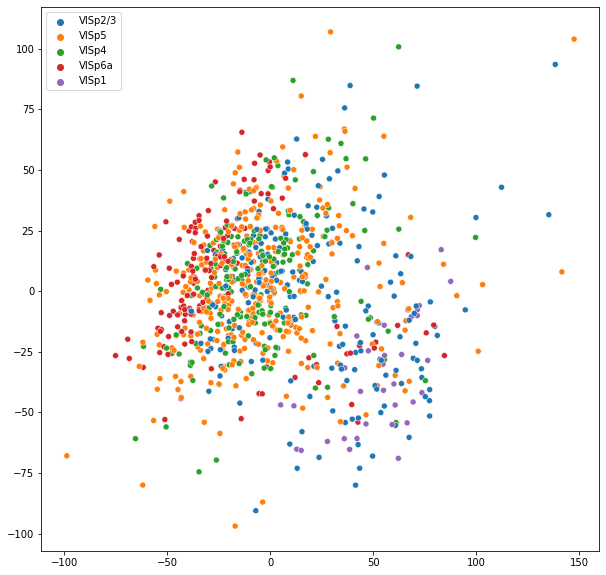

In [69]:
plt.figure(figsize=(10,10))
sns.scatterplot(x= x_pca[:,0], y=x_pca[:,1], hue=structure_list)

Text(0.5, 1.0, 'VISp dataset')

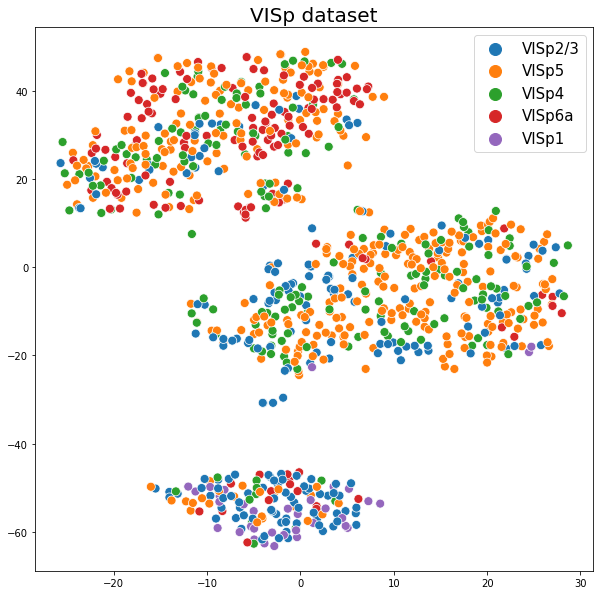

In [70]:
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= x_tsne[:,0], y=x_tsne[:,1], hue=structure_list, s=80)
plt.legend(markerscale=2, loc='best',fontsize=15)
ax.set_title('VISp dataset',fontdict={'size':20,})

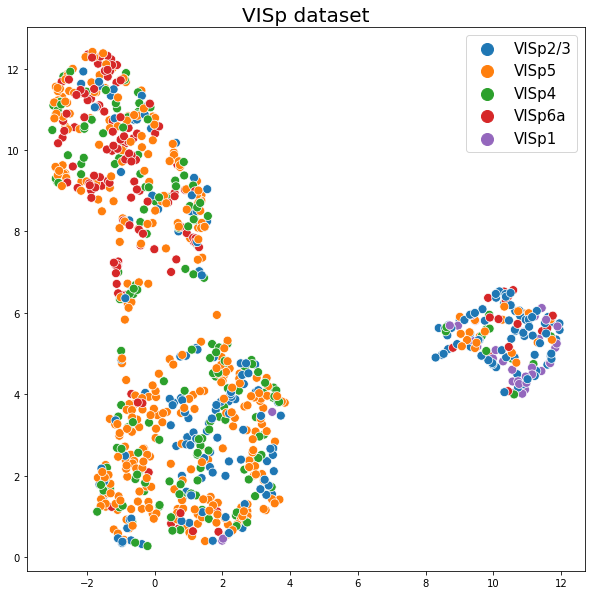

In [71]:
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= x_umap[:,0], y=x_umap[:,1], hue=structure_list, s=80)
plt.legend(markerscale=2, loc='best',fontsize=15)
ax.set_title('VISp dataset',fontdict={'size':20,})
plt.savefig(r'C:\Users\18056\Desktop\nr-editorial-policy-checklist(1)\VISp dataset_structure_label.png', dpi=200,bbox_inches='tight')

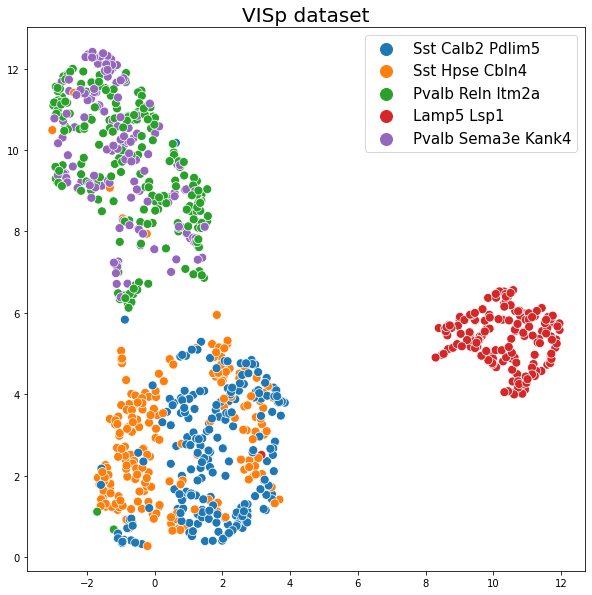

In [72]:
f,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x= x_umap[:,0], y=x_umap[:,1],hue=ttype_list,  s=80)
plt.legend(markerscale=2, loc='best',fontsize=15)
ax.set_title('VISp dataset',fontdict={'size':20,})
plt.savefig(r'C:\Users\18056\Desktop\nr-editorial-policy-checklist(1)\VISp dataset_genetic_label.png', dpi=200,bbox_inches='tight')